<center> <h1>Workshop: Regression Discontinuity Design</h1> </center> 
<center> <h2>Application: minimum legal drinking age</h2> </center> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.api import add_constant

### 0. Setup
This is an example of Regression Discontinuity design from "Mastering Metrics". In this example, we want to study the effect of having legal access to alcohol on mortality rates. In the U.S, people have legal access to alcohol after they turn 21 years old. Anecdotal data shows that there is a spike in the number of deaths per day on and right after a 21st birthday. Indeed, it has been observed that more than 100 people die on or right after their 21st birthday compared to those who died on or right after their 20th or 22nd birthday.

**The question is: Can the age-21 effect be attributed to the minimum legal dinking age (MLDA)?**


You can download the dataset from Canvas.


**Description** A data frame containing 48 observations on 7 covariates. Each observation corresponds to a 30 day interval. Observations are centered around the 21st birthday.

**agecell:**
Month of age (defined as a 30-day interval).

**all:**
All death rates per 100,000 persons per year.

**C = internal,external,alcohol (poisoning),homicide,suicide,mva (motor vehicle accidents):**
death rates per 100,000 persons per year due to C 





In [2]:
mlda = pd.read_csv('mlda.csv')
mlda.head()

,agecell,all,internal,external,alcohol,homicide,suicide,mva
0,19.068493,92.825401,16.617590,76.207817,0.639138,16.316818,11.203714,35.829327
1,19.150684,95.100739,18.327684,76.773056,0.677409,16.859964,12.193368,35.639256
2,19.232876,92.144295,18.911053,73.233238,0.866443,15.219254,11.715812,34.205650
3,19.315069,88.427757,16.101770,72.325981,0.867308,16.742825,11.275010,32.278957
4,19.397261,88.704941,17.363520,71.341415,1.019163,14.947726,10.984314,32.650967


**Do:**
1. Add to the dataset the columns "over21" and "age". The first is a dummy that takes the value 1 if "agecell" is greater or equal than 21. The second is: agelcell-21.
2. Add a column called "externalother" which equals "external" minus "suicide", "homicide", and "mva"

In [3]:
mlda["over21"] = (mlda["agecell"]>=21)
mlda["over21"] = mlda["over21"].astype(int)

In [4]:
mlda["age"] = mlda["agecell"]-21

In [5]:
mlda["externalother"] = mlda["external"] - mlda["homicide"]- mlda["suicide"]- mlda["mva"]

In [6]:
mlda.head()

,agecell,all,internal,external,alcohol,homicide,suicide,mva,over21,age,externalother
0,19.068493,92.825401,16.617590,76.207817,0.639138,16.316818,11.203714,35.829327,0,-1.931507,12.857958
1,19.150684,95.100739,18.327684,76.773056,0.677409,16.859964,12.193368,35.639256,0,-1.849316,12.080468
2,19.232876,92.144295,18.911053,73.233238,0.866443,15.219254,11.715812,34.205650,0,-1.767124,12.092523
3,19.315069,88.427757,16.101770,72.325981,0.867308,16.742825,11.275010,32.278957,0,-1.684931,12.029189
4,19.397261,88.704941,17.363520,71.341415,1.019163,14.947726,10.984314,32.650967,0,-1.602739,12.758409


### 1. Exploration

**Q:** Create a scatter plot of "all" vs "age". Consider a death rate equal to 95. What do you observe for this death rate? 

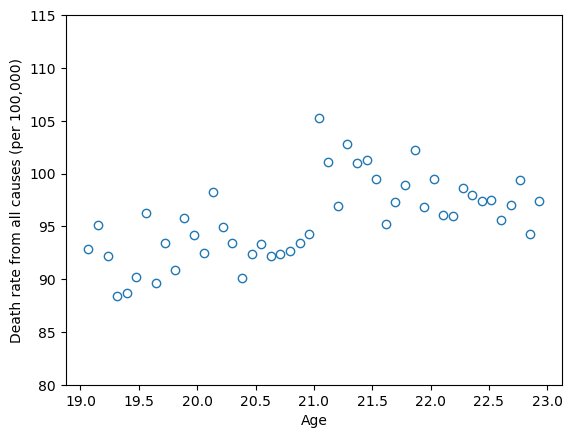

In [7]:
x = mlda['agecell']
y = mlda['all']
plt.plot(x, y, 'o',mfc = 'none') #scatter plot
plt.ylim([80, 115])
plt.xlabel("Age")
plt.ylabel("Death rate from all causes (per 100,000)")
plt.show()

**A:** Only a few death rates to the left of 21 are above 95. Right after 21, death rates go up, and only a few death rates to the right of 21 are below 95.

### 2. Setting up a Sharp RD

In this part, we will perform a simple RD design with linear trends.



**Q:** Regress all on a treatment dummy. Do you expect these results to be bias? If so, what is the direction of the bias?

In [8]:
simple_reg = smf.ols(formula = "all ~ over21 ", data = mlda).fit()
print(simple_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     61.77
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           4.77e-10
Time:                        02:17:45   Log-Likelihood:                -111.64
No. Observations:                  48   AIC:                             227.3
Df Residuals:                      46   BIC:                             231.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     92.8027      0.516    179.698      0.0

**A:** These result do not control for age. It is reasonable to expect that older people (in this age range) will be less likely to die (e.g., they become more mature). At the same time age is positively correlated with the treatment. From the OVB formula, the bias is negative and, therefore, we are potentially underestimatng the treatment effect.

**Q:** Why is this context suitable for RD? Define the elements of your RD design, and the regression you want to run. Run your regression and add the regression result to the scatter plot from the previous part.

**A:** Note that here there is a mechanical rule that determines the assignment of treatment: age above or below 21. 

$Y=$ All death rates per 100,000 persons per year.

$X=$ Age (this is the running variable).

$c = $ 21, the cutoff.

$D=$ legal drinking age. It is 1 if $X\ge c$, and 0 otherwise.

We run the following regression:

$$
Y = \alpha + \tau D + \beta X + e
$$



In [9]:
simple_RD = smf.ols(formula = "all ~ over21 + agecell", data = mlda).fit()
print(simple_RD.summary())

                            OLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     32.99
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.51e-09
Time:                        02:21:31   Log-Likelihood:                -110.41
No. Observations:                  48   AIC:                             226.8
Df Residuals:                      45   BIC:                             232.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    112.3097     12.668      8.866      0.0

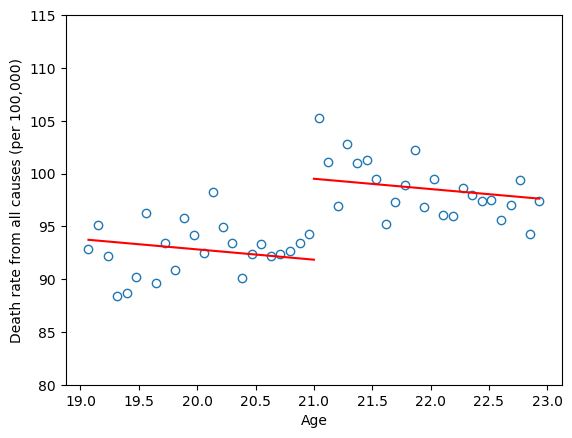

In [10]:
x = mlda['agecell']
y = mlda['all']
plt.plot(x, y, 'o',mfc = 'none') #scatter plot
intercept = simple_RD.params[0]
tau_coef = simple_RD.params[1]
age_coef = simple_RD.params[2]
#plt.plot(x, intercept + age_coef*x + tau_coef*(x>=21)) #regression line
x1 = x[x<21]
x2 = x[x>=21]
plt.plot(x1, intercept + age_coef*x1,'r')
plt.plot(x2, intercept + age_coef*x2 + tau_coef,'r')
plt.ylim([80, 115])
plt.xlabel("Age")
plt.ylabel("Death rate from all causes (per 100,000)")
plt.show()

**Q:** What is the resulting estimate of the treatment effect? How do you interpret it? Does OVB affect your results?

**A:** Our estimate is $\tau$ and it is equal to 7.7 which captures the jump in death rates at age 21. Assuming that the effect of age on death rate is captured by a linear function, there is no OVB to worry about because $D$ only depends on X which we are already controlling for. 

### 3. Nonlinear modeling

**Q 3.a:** Do you think the trend relationship between age and death rates changes at the cutoff? Why? Run a regression that allows for different slopes on both sides of the cutoff. Plot your results.

**A:** 
Two potential (hypothetical) theories:

(1) We might expect a decline on death rates as young people (to the left of the cutoff) mature and take fewer risks. After age 21, unrestricted access to alcohol may change this by (maybe) slowing down the declining rate.  

(2) It is possible that responsible legal drinking accelerates the development of mature behavior. 

Other theories are possible too.

In [11]:
interacted_RD_1 = smf.ols(formula = "all ~ over21 + age + age:over21", data = mlda).fit()
print(interacted_RD_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     29.47
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.33e-10
Time:                        02:23:30   Log-Likelihood:                -105.64
No. Observations:                  48   AIC:                             219.3
Df Residuals:                      44   BIC:                             226.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.6184      0.932    100.399      0.0

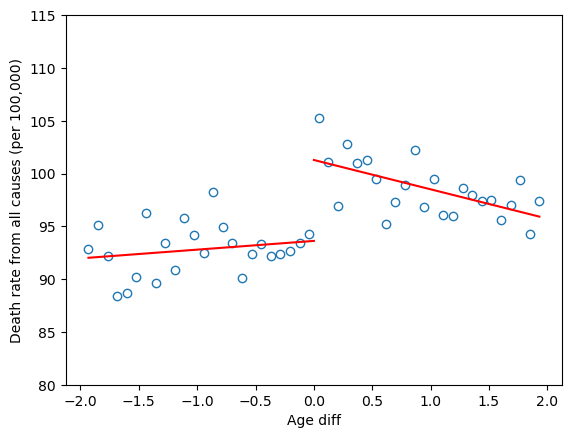

In [14]:
x = mlda['age']
y = mlda['all']
plt.plot(x, y, 'o',mfc = 'none') #scatter plot
intercept = interacted_RD_1.params[0]
tau_coef = interacted_RD_1.params[1]
age_coef = interacted_RD_1.params[2]
inter_coef = interacted_RD_1.params[3]
x1 = x[x<0]
x2 = x[x>=0]
#explain this code
plt.plot(x1, intercept + age_coef*x1,'r')

plt.plot(x2, intercept + age_coef*x2 + tau_coef + inter_coef*x2,'r')
plt.ylim([80, 115])
plt.xlabel("Age diff")
plt.ylabel("Death rate from all causes (per 100,000)")
plt.show()

**Q 3.b:** Build a model that allows for different linear and quadratic terms on both sides of the cutoff. Plot your result. How does the estimate you obtain compare to your previous estimates?

**A:**

In [15]:
interacted_RD_2 = smf.ols(formula = "all ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
print(interacted_RD_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     18.02
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.62e-09
Time:                        02:25:05   Log-Likelihood:                -104.57
No. Observations:                  48   AIC:                             221.1
Df Residuals:                      42   BIC:                             232.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

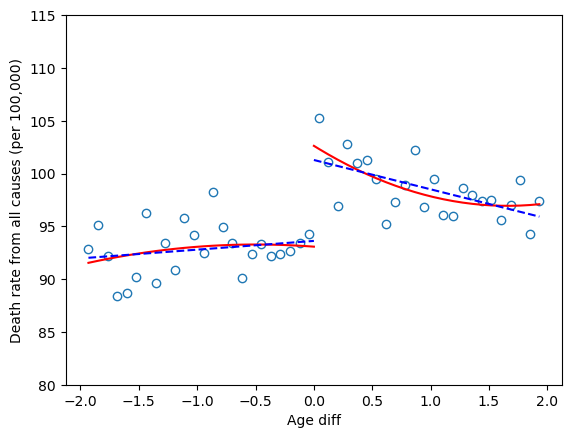

In [16]:
x = mlda['age']
y = mlda['all']
plt.plot(x, y, 'o',mfc = 'none') #scatter plot
m_intercept = interacted_RD_2.params[0]
m_tau_coef = interacted_RD_2.params[1]
m_age_coef_1 = interacted_RD_2.params[2]
m_inter_coef_1 = interacted_RD_2.params[3]
m_age_coef_2 = interacted_RD_2.params[4]
m_inter_coef_2 = interacted_RD_2.params[5]
x1 = x[x<0]
x2 = x[x>=0]
plt.plot(x1, m_intercept + m_age_coef_1*x1 + m_age_coef_2*x1*x1,'r')
plt.plot(x2, m_intercept + m_age_coef_1*x2 + m_tau_coef + m_inter_coef_1*x2 + m_age_coef_2*x2*x2 + m_inter_coef_2*x2*x2 ,'r')
plt.plot(x1, intercept + age_coef*x1,'b--')
plt.plot(x2, intercept + age_coef*x2 + tau_coef + inter_coef*x2,'b--')
plt.ylim([80, 115])
plt.xlabel("Age diff")
plt.ylabel("Death rate from all causes (per 100,000)")
plt.show()

We obtain a larger estimate of the MLDA effect of 9.5 death per 100,000 compared to the linear model. We seem to obtain a better fit than the simple model. The quadractic model is able to capture the sharp jump right after 21 and the speedy recovery that comes after.

**Q:** Which model would you prefer?

**A:** The key point is that the results are not highly sensitive to the details of our modeling choices. The simple RD model seems flexible enough to capture effects at the threshold. The more complex model captures the sharp increase in death rates after the cutoff, and also the subsequent partial recovery.

### 4. Checking the validity of our results

In this part, our goal is to exhaustively check our result so far. For this, we will run the specifications in **Q 3.a** and **Q 3.b** for all the different death rates. Compute all the treatment effect estimates and report the standard errors. Comment on your results.

**A:** In the code below I compute the estimates of both specifications and report the standard errors. I do it one by one for clarity but, in practice, you should try to make this in a more automated manner. 

In [17]:
#ALL
interacted_RD_1 = smf.ols(formula = "all ~ over21 + age + age:over21", data = mlda).fit()
interacted_RD_2 = smf.ols(formula = "all ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
data = [['all', tau_1,tau_2], ['stde', stde_1,stde_2]]


In [18]:
#MVA
interacted_RD_1 = smf.ols(formula = "mva ~ over21 + age + age:over21", data = mlda).fit()
interacted_RD_2 = smf.ols(formula = "mva ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
data.append(['mva', tau_1,tau_2])
data.append(['stde', stde_1,stde_2])

In [19]:
#suicide
interacted_RD_1 = smf.ols(formula = "suicide ~ over21 + age + age:over21", data = mlda).fit()
interacted_RD_2 = smf.ols(formula = "suicide ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
data.append(['suicide', tau_1,tau_2])
data.append(['stde', stde_1,stde_2])

In [20]:
#homicide
interacted_RD_1 = smf.ols(formula = "homicide ~ over21 + age + age:over21", data = mlda).fit()
interacted_RD_2 = smf.ols(formula = "homicide ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
data.append(['homicide', tau_1,tau_2])
data.append(['stde', stde_1,stde_2])

In [21]:
#externalother
interacted_RD_1 = smf.ols(formula = "externalother ~ over21 + age + age:over21", data = mlda).fit()
interacted_RD_2 = smf.ols(formula = "externalother ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
data.append(['externalother', tau_1,tau_2])
data.append(['stde', stde_1,stde_2])

In [22]:
#internal
interacted_RD_1 = smf.ols(formula = "internal ~ over21 + age + age:over21", data = mlda).fit()
interacted_RD_2 = smf.ols(formula = "internal ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
data.append(['internal', tau_1,tau_2])
data.append(['stde', stde_1,stde_2])

In [23]:
#alcohol
interacted_RD_1 = smf.ols(formula = "alcohol ~ over21 + age + age:over21", data = mlda).fit()
interacted_RD_2 = smf.ols(formula = "alcohol ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
data.append(['alcohol', tau_1,tau_2])
data.append(['stde', stde_1,stde_2])

In [24]:
# Create a pandas DataFrame
summary_of_results = pd.DataFrame(data, columns=['Dependent Variable', 'Specification (1)','Specification (2)'])
# print dataframe.
summary_of_results

,Dependent Variable,Specification (1),Specification (2)
0,all,7.662709,9.547789
1,stde,1.318704,1.985277
2,mva,4.534033,4.662858
3,stde,0.750604,1.154799
4,suicide,1.794289,1.814332
5,stde,0.454215,0.698861
6,homicide,0.104358,0.200221
7,stde,0.344630,0.522131
8,externalother,0.838112,1.797180
9,stde,0.488739,0.724117


**comments:**

1. There are strong effects of legal drinking on death by mva. This makes sense as alcohol is tied to motor vehicle accidents on young people. These effecs are large enough to account for most of the excess deaths related to the MLDA. Estimates are insensitive to the model we use.

2. Suicide and other external causes (including accidents other than car crashes) may also be affected by drinking. Our estimates for these effects are small but statistically significant. 

3. The estimates for internal causes are small and not significantly different from 0. 

4. Estimates for the effects from alcohol poisoning are small and similar to those for internal causes but significantly different from 0.

All in all these results show strong effect for causes atributable to alcohol and weak effects for causes that are not such as internal causes. 

**Q:** To conclude, plot the death rates for mva and for internal causes. Add the correspoding fit from the specification in **Q 3.b** What do you observe?

**A:**

In [25]:
interacted_RD_2_mva = smf.ols(formula = "mva ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()
interacted_RD_2_internal = smf.ols(formula = "internal ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = mlda).fit()

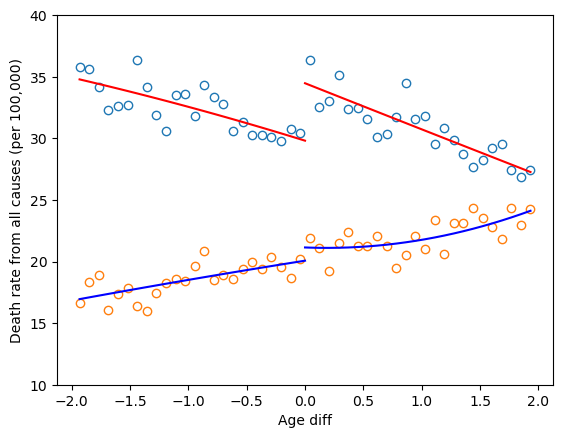

In [26]:
x = mlda['age']
#mva
y1 = mlda['mva']
plt.plot(x, y1, 'o',mfc = 'none') #scatter plot
m_intercept = interacted_RD_2_mva.params[0]
m_tau_coef = interacted_RD_2_mva.params[1]
m_age_coef_1 = interacted_RD_2_mva.params[2]
m_inter_coef_1 = interacted_RD_2_mva.params[3]
m_age_coef_2 = interacted_RD_2_mva.params[4]
m_inter_coef_2 = interacted_RD_2_mva.params[5]
x1 = x[x<0]
x2 = x[x>=0]
plt.plot(x1, m_intercept + m_age_coef_1*x1 + m_age_coef_2*x1*x1,'r')
plt.plot(x2, m_intercept + m_age_coef_1*x2 + m_tau_coef + m_inter_coef_1*x2 + m_age_coef_2*x2*x2 + m_inter_coef_2*x2*x2 ,'r')

#internal
y2 = mlda['internal']
plt.plot(x, y2, 'o',mfc = 'none') #scatter plot
intercept = interacted_RD_2_internal.params[0]
tau_coef = interacted_RD_2_internal.params[1]
age_coef_1 = interacted_RD_2_internal.params[2]
inter_coef_1 = interacted_RD_2_internal.params[3]
age_coef_2 = interacted_RD_2_internal.params[4]
inter_coef_2 = interacted_RD_2_internal.params[5]

plt.plot(x1, intercept + age_coef_1*x1 + age_coef_2*x1*x1,'b')
plt.plot(x2, intercept + age_coef_1*x2 + tau_coef + inter_coef_1*x2 + age_coef_2*x2*x2 + inter_coef_2*x2*x2 ,'b')

plt.ylim([10, 40])
plt.xlabel("Age diff")
plt.ylabel("Death rate from all causes (per 100,000)")
plt.show()

There is clear break at age 21 for MVA, and there is no evidence that we may be missing a nonlinear trend. We don't observe a significant jump for internal causes. The results from the previous question suggest that this jump may be due to random chance. 

### 5. Nonparamtric Approach

Considering ages between 20-21, compute all the treatment effect estimates using models **Q 3.a** and **Q3.b** and report the standard errors. Comment on your results. Do you think that RD design is giving the real causal effect for this data?

**A:**

In [27]:
new_mlda = mlda[(mlda.agecell >= 20) & (mlda.agecell <= 22)]

In [28]:
new_mlda.head()

,agecell,all,internal,external,alcohol,homicide,suicide,mva,over21,age,externalother
12,20.054794,92.464600,19.634459,72.830139,1.027384,17.199177,11.263178,31.772816,0,-0.945206,12.594969
13,20.136986,98.245598,20.883860,77.361740,0.952731,17.034826,11.928189,34.298309,0,-0.863014,14.100415
14,20.219177,94.960403,18.473003,76.487396,1.374025,16.297464,11.870050,33.320110,0,-0.780823,14.999771
15,20.301371,93.385323,18.883484,74.501839,0.993868,15.940106,12.461570,32.759403,0,-0.698629,13.340759
16,20.383562,90.120918,18.567820,71.553101,1.225093,16.883316,11.102407,30.589046,0,-0.616438,12.978331


In [29]:
#ALL
interacted_RD_1 = smf.ols(formula = "all ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "all ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data = [['all', tau_1,tau_2], ['stde', stde_1,stde_2]]

#MVA
interacted_RD_1 = smf.ols(formula = "mva ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "mva ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['mva', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])
#suicide
interacted_RD_1 = smf.ols(formula = "suicide ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "suicide ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['suicide', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])
#suicide
interacted_RD_1 = smf.ols(formula = "suicide ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "suicide ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['suicide', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])
#homicide
interacted_RD_1 = smf.ols(formula = "homicide ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "homicide ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['homicide', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])
#homicide
interacted_RD_1 = smf.ols(formula = "homicide ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "homicide ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['homicide', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])
#externalother
interacted_RD_1 = smf.ols(formula = "externalother ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "externalother ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['externalother', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])
#internal
interacted_RD_1 = smf.ols(formula = "internal ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "internal ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['internal', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])
#alcohol
interacted_RD_1 = smf.ols(formula = "alcohol ~ over21 + age + age:over21", data = new_mlda).fit()
interacted_RD_2 = smf.ols(formula = "alcohol ~ over21 + age + age:over21 + np.power(age,2) + np.power(age,2):over21", data = new_mlda).fit()
tau_1 = interacted_RD_1.params[1]
stde_1 = interacted_RD_1.bse[1]
tau_2 = interacted_RD_2.params[1]
stde_2 = interacted_RD_2.bse[1]
new_data.append(['alcohol', tau_1,tau_2])
new_data.append(['stde', stde_1,stde_2])


In [30]:
# Create a pandas DataFrame
new_summary_of_results = pd.DataFrame(new_data, columns=['Dependent Variable', 'Specification (1)','Specification (2)'])
# print dataframe.
new_summary_of_results

,Dependent Variable,Specification (1),Specification (2)
0,all,9.753311,9.611077
1,stde,1.937052,2.894032
2,mva,4.759284,5.892489
3,stde,1.123447,1.561275
4,suicide,1.724426,1.296599
5,stde,0.709664,1.125703
6,suicide,1.724426,1.296599
7,stde,0.709664,1.125703
8,homicide,0.163819,-0.452693
9,stde,0.517226,0.787663


Overall, nonparametric and parametric estimates are similar. Our paramtric estimates are for the most part insensitive to the choice of bandwidth. The robustness of these result suggests that we are estimating the real causal effect.